In [1]:
import numpy as np
import joblib
import tensorflow as tf
# noinspection PyUnresolvedReferences
import tensorflow.experimental.numpy as tnp
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input, Dense, Lambda, Subtract, Add, Reshape
from tensorflow.keras.models import Model
from sklearn.utils import shuffle


def smape_loss(y_true, y_pred):
    """
    sMAPE loss as defined in "Appendix A" of
    http://www.forecastingprinciples.com/files/pdf/Makridakia-The%20M3%20Competition.pdf
    :return: Loss value
    """
    # mask=tf.where(y_true,1.,0.)
    mask = tf.cast(y_true, tf.bool)
    mask = tf.cast(mask, tf.float32)
    sym_sum = tf.abs(y_true) + tf.abs(y_pred)
    condition = tf.cast(sym_sum, tf.bool)
    weights = tf.where(condition, 1. / (sym_sum + 1e-8), 0.0)
    return 200 * tnp.nanmean(tf.abs(y_pred - y_true) * weights * mask)


class NBeatsNetTensor:
    GENERIC_BLOCK = 'generic'
    TREND_BLOCK = 'trend'
    SEASONALITY_BLOCK = 'seasonality'

    _BACKCAST = 'backcast'
    _FORECAST = 'forecast'

    def __init__(self,
                 input_dim=1,
                 output_dim=1,
                 exo_dim=0,
                 backcast_length=10,
                 forecast_length=1,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):

        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.thetas_dim = thetas_dim
        self.units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.exo_dim = exo_dim
        self.input_shape = (self.backcast_length, self.input_dim)
        self.exo_shape = (self.backcast_length, self.exo_dim)
        self.output_shape = (self.forecast_length, self.output_dim)
        self.weights = {}
        self.nb_harmonics = nb_harmonics
        assert len(self.stack_types) == len(self.thetas_dim)

        x = Input(shape=self.input_shape, name='input_variable')
        x_ = {}
        for k in range(self.input_dim):
            x_[k] = Lambda(lambda z: z[..., k])(x)
        e_ = {}
        if self.has_exog():
            e = Input(shape=self.exo_shape, name='exos_variables')
            for k in range(self.exo_dim):
                e_[k] = Lambda(lambda z: z[..., k])(e)
        else:
            e = None
        y_ = {}

        for stack_id in range(len(self.stack_types)):
            stack_type = self.stack_types[stack_id]
            nb_poly = self.thetas_dim[stack_id]
            for block_id in range(self.nb_blocks_per_stack):
                backcast, forecast = self.create_block(x_, e_, stack_id, block_id, stack_type, nb_poly)
                for k in range(self.input_dim):
                    x_[k] = Subtract()([x_[k], backcast[k]])
                    if stack_id == 0 and block_id == 0:
                        y_[k] = forecast[k]
                    else:
                        y_[k] = Add()([y_[k], forecast[k]])

        for k in range(self.input_dim):
            y_[k] = Reshape(target_shape=(self.forecast_length, 1))(y_[k])
            x_[k] = Reshape(target_shape=(self.backcast_length, 1))(x_[k])
        if self.input_dim > 1:
            y_ = Concatenate()([y_[ll] for ll in range(self.input_dim)])
            x_ = Concatenate()([x_[ll] for ll in range(self.input_dim)])
        else:
            y_ = y_[0]
            x_ = x_[0]

        if self.input_dim != self.output_dim:
            y_ = Dense(self.output_dim, activation='linear', name='reg_y')(y_)
            x_ = Dense(self.output_dim, activation='linear', name='reg_x')(x_)

        inputs_x = [x, e] if self.has_exog() else x
        n_beats_forecast = Model(inputs_x, y_, name=self._FORECAST)
        n_beats_backcast = Model(inputs_x, x_, name=self._BACKCAST)

        self.models = {model.name: model for model in [n_beats_backcast, n_beats_forecast]}
        self.cast_type = self._FORECAST

    def has_exog(self):
        # exo/exog is short for 'exogenous variable', i.e. any input
        # features other than the target time-series itself.
        return self.exo_dim > 0

    @staticmethod
    def load(filepath, custom_objects=None, compile=True):
        from tensorflow.keras.models import load_model
        return load_model(filepath, custom_objects, compile)

    def _r(self, layer_with_weights, stack_id):
        # mechanism to restore weights when block share the same weights.
        # only useful when share_weights_in_stack=True.
        if self.share_weights_in_stack:
            layer_name = layer_with_weights.name.split('/')[-1]
            try:
                reused_weights = self.weights[stack_id][layer_name]
                return reused_weights
            except KeyError:
                pass
            if stack_id not in self.weights:
                self.weights[stack_id] = {}
            self.weights[stack_id][layer_name] = layer_with_weights
        return layer_with_weights

    def create_block(self, x, e, stack_id, block_id, stack_type, nb_poly):
        # register weights (useful when share_weights_in_stack=True)
        def reg(layer):
            return self._r(layer, stack_id)

        # update name (useful when share_weights_in_stack=True)
        def n(layer_name):
            return '/'.join([str(stack_id), str(block_id), stack_type, layer_name])

        backcast_ = {}
        forecast_ = {}
        d1 = reg(Dense(self.units, activation='relu', name=n('d1')))
        d2 = reg(Dense(self.units, activation='relu', name=n('d2')))
        d3 = reg(Dense(self.units, activation='relu', name=n('d3')))
        d4 = reg(Dense(self.units, activation='relu', name=n('d4')))
        if stack_type == 'generic':
            theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = reg(Dense(self.backcast_length, activation='linear', name=n('backcast')))
            forecast = reg(Dense(self.forecast_length, activation='linear', name=n('forecast')))
        elif stack_type == 'trend':
            theta_f = theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f_b')))
            backcast = Lambda(trend_model, arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
            forecast = Lambda(trend_model, arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
        else:  # 'seasonality'
            if self.nb_harmonics:
                theta_b = reg(Dense(self.nb_harmonics, activation='linear', use_bias=False, name=n('theta_b')))
            else:
                theta_b = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = Lambda(seasonality_model,
                              arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
            forecast = Lambda(seasonality_model,
                              arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
        for k in range(self.input_dim):
            if self.has_exog():
                d0 = Concatenate()([x[k]] + [e[ll] for ll in range(self.exo_dim)])
            else:
                d0 = x[k]
            d1_ = d1(d0)
            d2_ = d2(d1_)
            d3_ = d3(d2_)
            d4_ = d4(d3_)
            theta_f_ = theta_f(d4_)
            theta_b_ = theta_b(d4_)
            backcast_[k] = backcast(theta_b_)
            forecast_[k] = forecast(theta_f_)

        return backcast_, forecast_

    def __getattr__(self, name):
        # https://github.com/faif/python-patterns
        # model.predict() instead of model.n_beats.predict()
        # same for fit(), train_on_batch()...
        attr = getattr(self.models[self._FORECAST], name)

        if not callable(attr):
            return attr

        def wrapper(*args, **kwargs):
            cast_type = self._FORECAST
            if attr.__name__ == 'predict' and 'return_backcast' in kwargs and kwargs['return_backcast']:
                del kwargs['return_backcast']
                cast_type = self._BACKCAST
            return getattr(self.models[cast_type], attr.__name__)(*args, **kwargs)

        return wrapper


def linear_space(backcast_length, forecast_length, is_forecast=True):
    # ls = K.arange(-float(backcast_length), float(forecast_length), 1) / forecast_length
    # return ls[backcast_length:] if is_forecast else K.abs(K.reverse(ls[:backcast_length], axes=0))
    horizon = forecast_length if is_forecast else backcast_length
    return K.arange(0, horizon) / horizon


def seasonality_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.get_shape().as_list()[-1]
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    s1 = K.stack([K.cos(2 * np.pi * i * t) for i in range(p1)])
    s2 = K.stack([K.sin(2 * np.pi * i * t) for i in range(p2)])
    if p == 1:
        s = s2
    else:
        s = K.concatenate([s1, s2], axis=0)
    s = K.cast(s, np.float32)
    return K.dot(thetas, s)


def trend_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.shape[-1]
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    t = K.transpose(K.stack([t ** i for i in range(p)]))
    t = K.cast(t, np.float32)
    return K.dot(thetas, K.transpose(t))

In [2]:
import pickle
import random
from time import time
from typing import Union

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import mse_loss, l1_loss, binary_cross_entropy, cross_entropy
from torch.optim import Optimizer


class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    GENERIC_BLOCK = 'generic'

    def __init__(self,
                 device=torch.device('cpu'),
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 forecast_length=5,
                 backcast_length=10,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dim
        self.parameters = []
        self.device = device
        print('| N-Beats')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)
        self._loss = None
        self._opt = None

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(self.hidden_layer_units, self.thetas_dim[stack_id],
                                   self.device, self.backcast_length, self.forecast_length, self.nb_harmonics)
                self.parameters.extend(block.parameters())
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    def save(self, filename: str):
        torch.save(self, filename)

    @staticmethod
    def load(f, map_location=None, pickle_module=pickle, **pickle_load_args):
        return torch.load(f, map_location, pickle_module, **pickle_load_args)

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def compile(self, loss: str, optimizer: Union[str, Optimizer]):
        if loss == 'mae':
            loss_ = l1_loss
        elif loss == 'mse':
            loss_ = mse_loss
        elif loss == 'cross_entropy':
            loss_ = cross_entropy
        elif loss == 'binary_crossentropy':
            loss_ = binary_cross_entropy
        else:
            raise ValueError(f'Unknown loss name: {loss}.')
        # noinspection PyArgumentList
        if isinstance(optimizer, str):
            if optimizer == 'adam':
                opt_ = optim.Adam
            elif optimizer == 'sgd':
                opt_ = optim.SGD
            elif optimizer == 'rmsprop':
                opt_ = optim.RMSprop
            else:
                raise ValueError(f'Unknown opt name: {optimizer}.')
            opt_ = opt_(lr=1e-4, params=self.parameters())
        else:
            opt_ = optimizer
        self._opt = opt_
        self._loss = loss_

    def fit(self, x_train, y_train, validation_data=None, epochs=10, batch_size=32):

        def split(arr, size):
            arrays = []
            while len(arr) > size:
                slice_ = arr[:size]
                arrays.append(slice_)
                arr = arr[size:]
            arrays.append(arr)
            return arrays

        for epoch in range(epochs):
            x_train_list = split(x_train, batch_size)
            y_train_list = split(y_train, batch_size)
            assert len(x_train_list) == len(y_train_list)
            shuffled_indices = list(range(len(x_train_list)))
            random.shuffle(shuffled_indices)
            self.train()
            train_loss = []
            timer = time()
            for batch_id in shuffled_indices:
                batch_x, batch_y = x_train_list[batch_id], y_train_list[batch_id]
                self._opt.zero_grad()
                _, forecast = self(torch.tensor(batch_x, dtype=torch.float).to(self.device))
                loss = self._loss(forecast, squeeze_last_dim(torch.tensor(batch_y, dtype=torch.float).to(self.device)))
                train_loss.append(loss.item())
                loss.backward()
                self._opt.step()
            elapsed_time = time() - timer
            train_loss = np.mean(train_loss)

            test_loss = '[undefined]'
            if validation_data is not None:
                x_test, y_test = validation_data
                self.eval()
                _, forecast = self(torch.tensor(x_test, dtype=torch.float).to(self.device))
                test_loss = self._loss(forecast, squeeze_last_dim(torch.tensor(y_test, dtype=torch.float))).item()

            num_samples = len(x_train_list)
            time_per_step = int(elapsed_time / num_samples * 1000)
            print(f'Epoch {str(epoch + 1).zfill(len(str(epochs)))}/{epochs}')
            print(f'{num_samples}/{num_samples} [==============================] - '
                  f'{int(elapsed_time)}s {time_per_step}ms/step - '
                  f'loss: {train_loss:.4f} - val_loss: {test_loss:.4f}')

    def predict(self, x, return_backcast=False):
        self.eval()
        b, f = self(torch.tensor(x, dtype=torch.float).to(self.device))
        b, f = b.detach().numpy(), f.detach().numpy()
        if len(x.shape) == 3:
            b = np.expand_dims(b, axis=-1)
            f = np.expand_dims(f, axis=-1)
        if return_backcast:
            return b
        return f

    def forward(self, backcast):
        backcast = squeeze_last_dim(backcast)
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return backcast, forecast


def squeeze_last_dim(tensor):
    if len(tensor.shape) == 3 and tensor.shape[-1] == 1:  # (128, 10, 1) => (128, 10).
        return tensor[..., 0]
    return tensor


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()  # H/2-1
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))


def linear_space(backcast_length, forecast_length, is_forecast=True):
    horizon = forecast_length if is_forecast else backcast_length
    return np.arange(0, horizon) / horizon


class Block(nn.Module):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace = linear_space(backcast_length, forecast_length, is_forecast=False)
        self.forecast_linspace = linear_space(backcast_length, forecast_length, is_forecast=True)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = squeeze_last_dim(x)
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = self.theta_b_fc(x)
        theta_f = self.theta_f_fc(x)

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast

In [3]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F

warnings.filterwarnings(action='ignore', message='Setting attributes')


In [4]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch


In [5]:
!wget https://raw.githubusercontent.com/sanyaver-blue/nbeats/main/ca-central-1-processed-2022-07-25.csv

--2022-07-27 12:21:20--  https://raw.githubusercontent.com/sanyaver-blue/nbeats/main/ca-central-1-processed-2022-07-25.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120458 (118K) [text/plain]
Saving to: ‘ca-central-1-processed-2022-07-25.csv’

ca-central-1-proces 100%[===================>] 117.63K  --.-KB/s    in 0.03s   

2022-07-27 12:21:20 (4.50 MB/s) - ‘ca-central-1-processed-2022-07-25.csv’ saved [120458/120458]



In [6]:
def availability(pred_values, orig_values):

  neg, pos = getCounts(pred_values, orig_values)

  print(neg)
  print(pos)
  predsSum, trueSum = sum(pred_values), sum(orig_values)

  availability = 100-((-neg)/trueSum)*100
  idlePercentage = (pos/trueSum)*100
  print(f"Availability: {availability}, Idle Percentage: {idlePercentage}")

orig_values = []
pred_values = []

def getCounts(pred, true, biasVal=0):
    #pred = pred.reshape(-1, 1).squeeze()
    #true = true.reshape(-1, 1).squeeze()
    pred = pred.tolist()
    true = true.tolist()
    print(pred,true)
    diff = list(np.array(pred) - np.array(true))
    baseline = 0
    diffs = list(diff)
    numPos = 0
    numNeg = 0
    maxNeg = min(diff)
    maxPos = max(diff)
    #print(max(dataset["Preds"]), min(dataset["Preds"]), max(dataset["True"]), min(dataset["True"]))
    #print(maxNeg, maxPos)
    for i in diffs:
        if(i>=0):
            numPos+=i
        else:
            numNeg+=i
    return numNeg, numPos


In [7]:
def my_custom_loss(predictions, y,unserved_penalty_weight):
    temp = predictions - y
    print(temp)
    posvals = temp[tf.where(temp>0)]**2
    negVals = temp[tf.where(temp<0)]**2
    posComp = tf.math.reduce_mean(posvals*1)
    negComp = tf.math.reduce_mean(negVals*unserved_penalty_weight)
    if tf.isnan(posComp) == False and tf.isnan(negComp) == False:
        return posComp+negComp
    elif tf.isnan(posComp) == True and tf.isnan(negComp) == False:
        return negComp
    elif tf.isnan(posComp) == False and tf.isnan(negComp) == True:
        return posComp


In [8]:
milk = pd.read_csv("/content/ca-central-1-processed-2022-07-25.csv", parse_dates=True) 
print(milk.head())
milk = milk.values.flatten()  # just keep np array here for simplicity.

   serving_instances_with_unserved_users
0                                    658
1                                    673
2                                    682
3                                    619
4                                    641


(32700,) (32700,)
[[0.2895189  0.28608247 0.28865979 0.29123711 0.28350515 0.27920962
  0.28178694 0.27920962 0.28092784 0.27405498]
 [0.28608247 0.28865979 0.29123711 0.28350515 0.27920962 0.28178694
  0.27920962 0.28092784 0.27405498 0.2637457 ]
 [0.28865979 0.29123711 0.28350515 0.27920962 0.28178694 0.27920962
  0.28092784 0.27405498 0.2637457  0.25601375]
 [0.29123711 0.28350515 0.27920962 0.28178694 0.27920962 0.28092784
  0.27405498 0.2637457  0.25601375 0.24828179]
 [0.28350515 0.27920962 0.28178694 0.27920962 0.28092784 0.27405498
  0.2637457  0.25601375 0.24828179 0.25429553]]
[[0.2637457  0.25601375 0.24828179]
 [0.25601375 0.24828179 0.25429553]
 [0.24828179 0.25429553 0.26116838]
 [0.25429553 0.26116838 0.26116838]
 [0.26116838 0.26116838 0.25859107]]
(26149, 10) (26149, 3) (6538, 10) (6538, 3)
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=10, forecast_length=3, share_thetas=False) at @1402

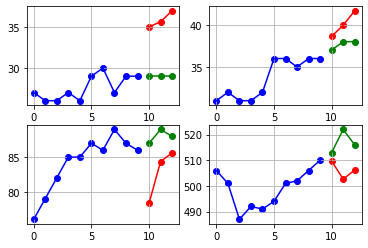

epoch = 0000, grad_step = 000349, tr_loss (epoch) = 11.865, te_loss (epoch) = 0.019


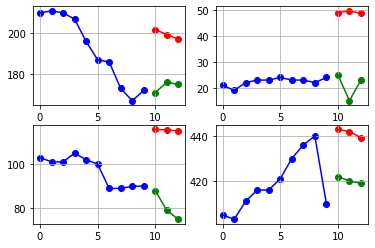

epoch = 0010, grad_step = 003839, tr_loss (epoch) = 0.055, te_loss (epoch) = 0.044


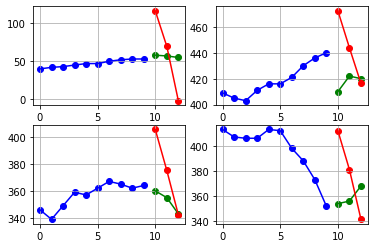

epoch = 0020, grad_step = 007329, tr_loss (epoch) = 0.057, te_loss (epoch) = 0.126


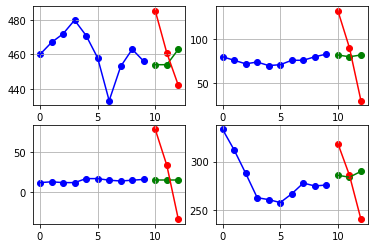

epoch = 0030, grad_step = 010819, tr_loss (epoch) = 0.053, te_loss (epoch) = 0.099


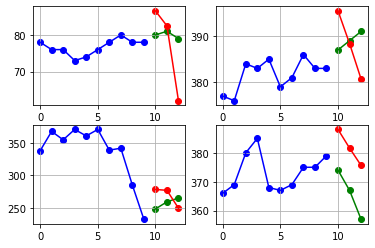

epoch = 0040, grad_step = 014309, tr_loss (epoch) = 0.041, te_loss (epoch) = 0.016


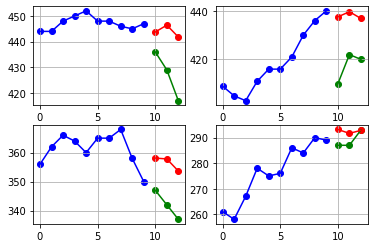

epoch = 0050, grad_step = 017799, tr_loss (epoch) = 0.041, te_loss (epoch) = 0.009


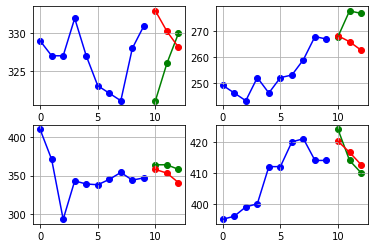

epoch = 0060, grad_step = 021289, tr_loss (epoch) = 0.032, te_loss (epoch) = 0.012


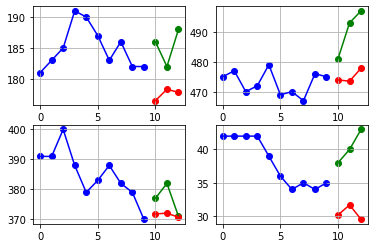

epoch = 0070, grad_step = 024779, tr_loss (epoch) = 0.045, te_loss (epoch) = 0.010


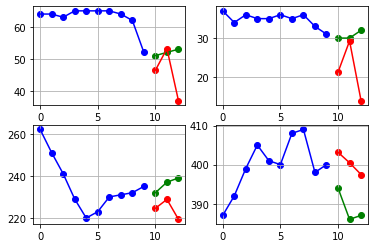

epoch = 0080, grad_step = 028269, tr_loss (epoch) = 0.033, te_loss (epoch) = 0.015


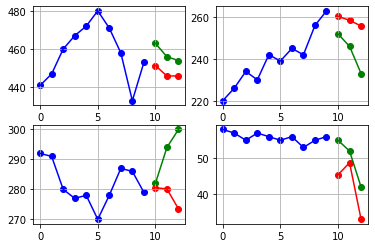

epoch = 0090, grad_step = 031759, tr_loss (epoch) = 0.032, te_loss (epoch) = 0.015


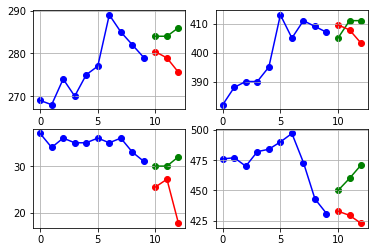

epoch = 0100, grad_step = 035249, tr_loss (epoch) = 0.031, te_loss (epoch) = 0.013


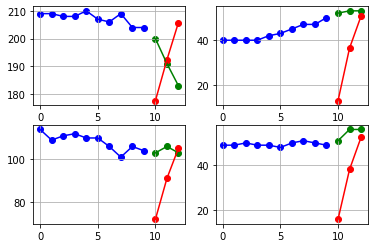

epoch = 0110, grad_step = 038739, tr_loss (epoch) = 0.030, te_loss (epoch) = 0.025


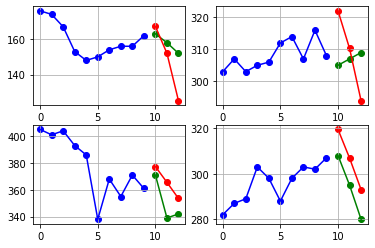

epoch = 0120, grad_step = 042229, tr_loss (epoch) = 0.031, te_loss (epoch) = 0.029


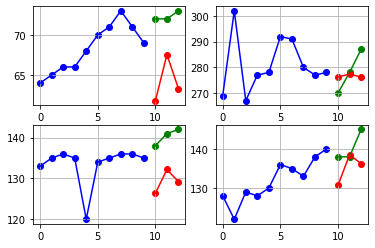

epoch = 0130, grad_step = 045719, tr_loss (epoch) = 0.028, te_loss (epoch) = 0.010


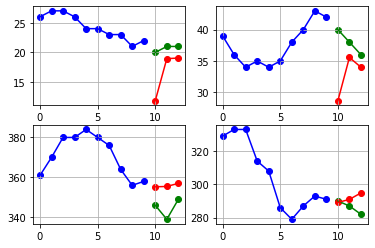

epoch = 0140, grad_step = 049209, tr_loss (epoch) = 0.028, te_loss (epoch) = 0.011


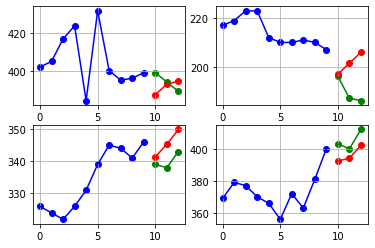

epoch = 0150, grad_step = 052699, tr_loss (epoch) = 0.029, te_loss (epoch) = 0.011


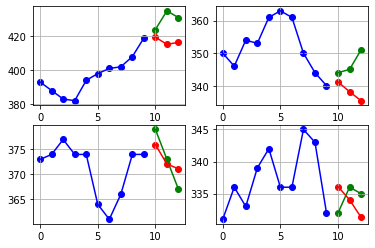

epoch = 0160, grad_step = 056189, tr_loss (epoch) = 0.030, te_loss (epoch) = 0.013


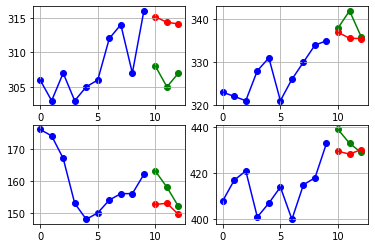

epoch = 0170, grad_step = 059679, tr_loss (epoch) = 0.027, te_loss (epoch) = 0.009


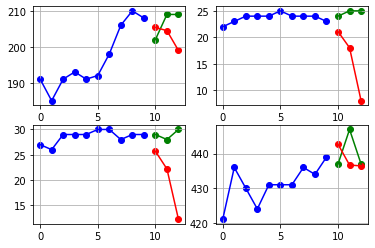

epoch = 0180, grad_step = 063169, tr_loss (epoch) = 0.029, te_loss (epoch) = 0.014


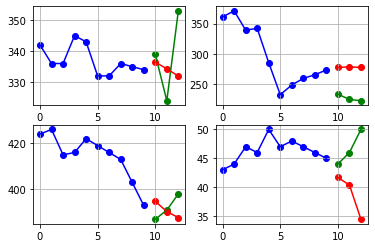

epoch = 0190, grad_step = 066659, tr_loss (epoch) = 0.025, te_loss (epoch) = 0.010


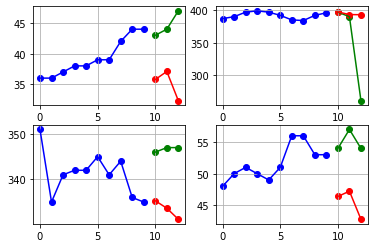

epoch = 0200, grad_step = 070149, tr_loss (epoch) = 0.028, te_loss (epoch) = 0.011


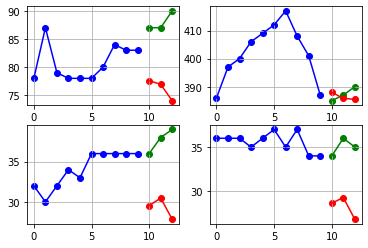

epoch = 0210, grad_step = 073639, tr_loss (epoch) = 0.025, te_loss (epoch) = 0.010


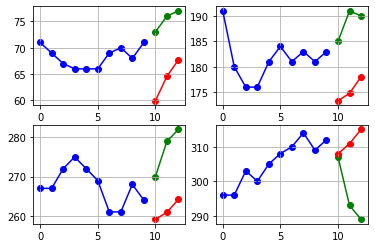

epoch = 0220, grad_step = 077129, tr_loss (epoch) = 0.027, te_loss (epoch) = 0.010


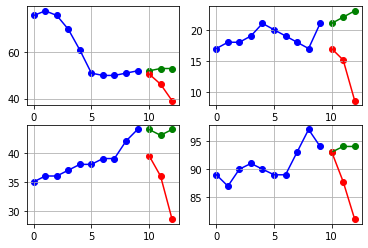

epoch = 0230, grad_step = 080619, tr_loss (epoch) = 0.025, te_loss (epoch) = 0.011


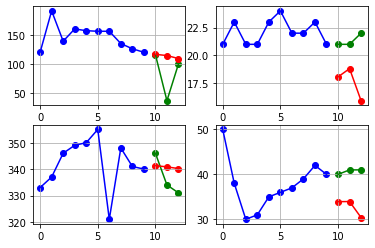

epoch = 0240, grad_step = 084109, tr_loss (epoch) = 0.024, te_loss (epoch) = 0.009


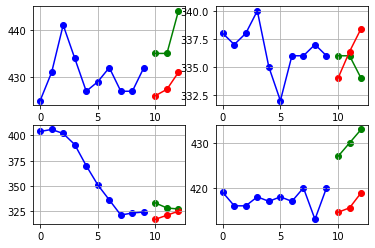

epoch = 0250, grad_step = 087599, tr_loss (epoch) = 0.024, te_loss (epoch) = 0.010


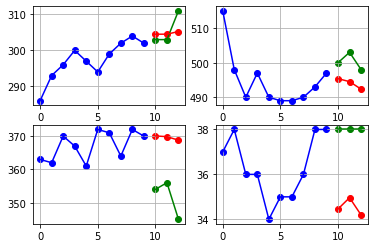

epoch = 0260, grad_step = 091089, tr_loss (epoch) = 0.024, te_loss (epoch) = 0.008


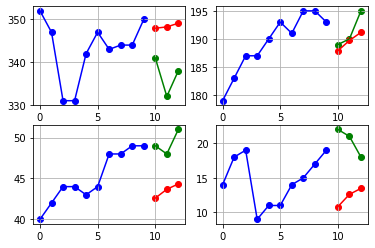

epoch = 0270, grad_step = 094579, tr_loss (epoch) = 0.024, te_loss (epoch) = 0.010


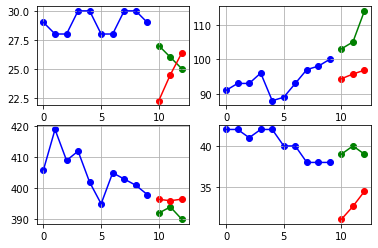

epoch = 0280, grad_step = 098069, tr_loss (epoch) = 0.023, te_loss (epoch) = 0.009


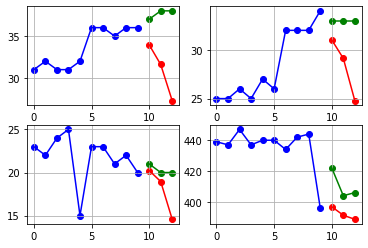

epoch = 0290, grad_step = 101559, tr_loss (epoch) = 0.024, te_loss (epoch) = 0.009


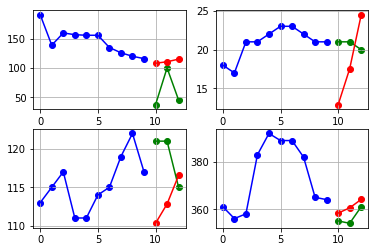

epoch = 0300, grad_step = 105049, tr_loss (epoch) = 0.023, te_loss (epoch) = 0.010


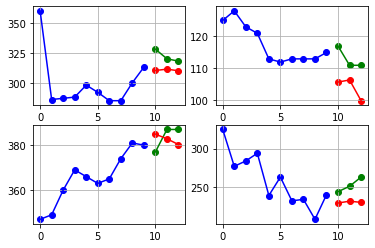

epoch = 0310, grad_step = 108539, tr_loss (epoch) = 0.024, te_loss (epoch) = 0.010


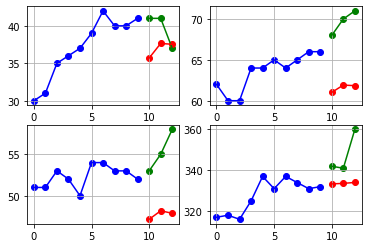

epoch = 0320, grad_step = 112029, tr_loss (epoch) = 0.022, te_loss (epoch) = 0.009


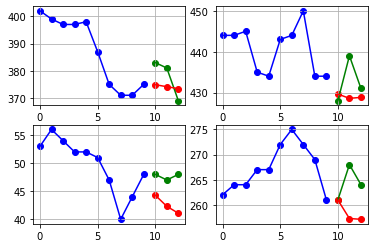

epoch = 0330, grad_step = 115519, tr_loss (epoch) = 0.023, te_loss (epoch) = 0.009


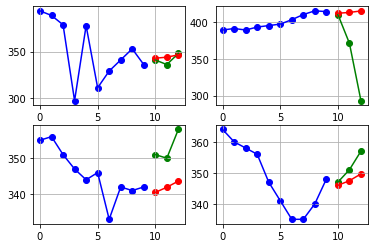

epoch = 0340, grad_step = 119009, tr_loss (epoch) = 0.023, te_loss (epoch) = 0.009


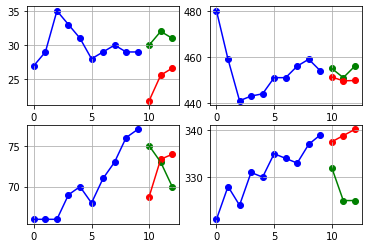

epoch = 0350, grad_step = 122499, tr_loss (epoch) = 0.022, te_loss (epoch) = 0.009


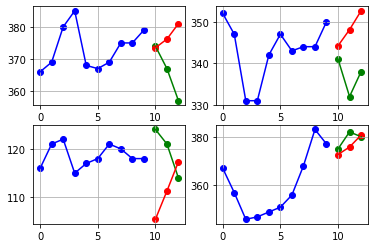

epoch = 0360, grad_step = 125989, tr_loss (epoch) = 0.022, te_loss (epoch) = 0.011


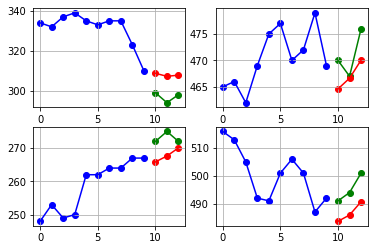

epoch = 0370, grad_step = 129479, tr_loss (epoch) = 0.022, te_loss (epoch) = 0.009


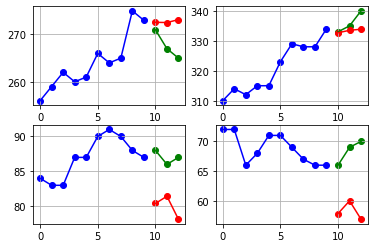

epoch = 0380, grad_step = 132969, tr_loss (epoch) = 0.022, te_loss (epoch) = 0.010


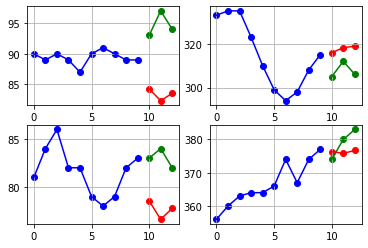

epoch = 0390, grad_step = 136459, tr_loss (epoch) = 0.022, te_loss (epoch) = 0.009
20.000000000000004 20.560913
42.0 39.62572
492.0 480.82172
99.0 111.041756


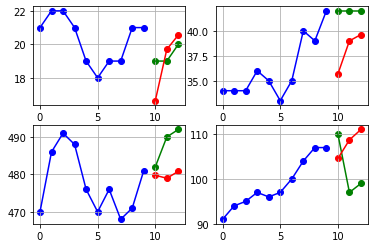

epoch = 0400, grad_step = 139949, tr_loss (epoch) = 0.023, te_loss (epoch) = 0.008
[20.000000000000004, 42.0, 492.0, 99.0] [20.5609130859375, 39.6257209777832, 480.82171630859375, 111.04175567626953]
-12.602668762207028
13.552562713623047
Availability: 98.06722387661601, Idle Percentage: 2.078454184410983
[20.000000000000004, 42.0, 492.0, 99.0] [20.5609130859375, 39.6257209777832, 480.82171630859375, 111.04175567626953]


In [9]:
def main(orig,pred):
    orig_values=orig
    pred_values=pred
    forecast_length = 3
    backcast_length = 10
    batch_size = 75  # greater than 4 for viz


    from sklearn.preprocessing import MinMaxScaler
    import joblib

    sc = MinMaxScaler()

    # milk = np.array(milk)
    sc.fit(np.array(milk).reshape(-1, 1))
    scaled_data =sc.transform(np.array(milk).reshape(-1, 1))
    joblib.dump(sc, "scaler_nbeats.save") 

    scaled_data = scaled_data.squeeze()
    
    print(milk.shape, scaled_data.shape)
    

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(scaled_data) - forecast_length):
        x.append(scaled_data[epoch - backcast_length:epoch])
        y.append(scaled_data[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]
    print(x_test[0:5])
    print(y_test[0:5])

    print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

    # normalization.

    #norm_constant = np.MinMaxScaler(x_train)
    #x_train, y_train = x_train / norm_constant, y_train / norm_constant
    #x_test, y_test = x_test / norm_constant, y_test / norm_constant
    #change to min max scaling

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=128,
    )
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())

    #col_names = ["x", "y", "predicted"]


    grad_step = 0
    for epoch in range(401):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
          x_train_batch, y_train_batch = shuffle(x_train_batch, y_train_batch , random_state=184745)
          grad_step += 1
          optimiser.zero_grad()
          _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
          loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
          train_loss.append(loss.item())
          loss.backward()
          optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()

        

        if epoch % 10 == 0:

            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = sc.inverse_transform(p[i].reshape(-1, 1)), sc.inverse_transform(x_test[i].reshape(-1, 1)), sc.inverse_transform(y_test[i].reshape(-1, 1))
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
                if epoch == 400:
                  ff = ff[2]
                  yy = yy[2]
                  
                  yy = yy.reshape(-1, 1).squeeze()
                  ff = ff.reshape(-1, 1).squeeze()
                  print(yy,ff)
                  if type(orig_values) != list:
                    orig_values.tolist()
                  if type(pred_values) != list:
                    pred_values.tolist()
                  #orig_values = orig_values.tolist()
                  #pred_values = pred_values.tolist()
                  orig_values.append(yy.tolist())
                  pred_values.append(ff.tolist())
                  

            plt.show()
        
           
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {100 * train_loss:.3f}, '
                  f'te_loss (epoch) = {100 * test_loss:.3f}')

        net.save('n_beats_model.h5')
        
if __name__ == '__main__':
    orig_values = []
    pred_values = []
    main(orig_values,pred_values)
    
  
    availability(np.array(orig_values),np.array(pred_values))

    print(orig_values, pred_values)

In [10]:
net = NBeatsNet.load('n_beats_model.h5')
print(net)


NBeatsNet(
  (parameters): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 128x10]
      (1): Parameter containing: [torch.FloatTensor of size 128]
      (2): Parameter containing: [torch.FloatTensor of size 128x128]
      (3): Parameter containing: [torch.FloatTensor of size 128]
      (4): Parameter containing: [torch.FloatTensor of size 128x128]
      (5): Parameter containing: [torch.FloatTensor of size 128]
      (6): Parameter containing: [torch.FloatTensor of size 128x128]
      (7): Parameter containing: [torch.FloatTensor of size 128]
      (8): Parameter containing: [torch.FloatTensor of size 4x128]
      (9): Parameter containing: [torch.FloatTensor of size 4x128]
      (10): Parameter containing: [torch.FloatTensor of size 10x4]
      (11): Parameter containing: [torch.FloatTensor of size 10]
      (12): Parameter containing: [torch.FloatTensor of size 3x4]
      (13): Parameter containing: [torch.FloatTensor of size 3]
      (14): Parameter conta

In [11]:
net.eval()
import numpy as np
sc = joblib.load("scaler_nbeats.save")
servers = milk[25000:len(milk)]
#servers=[1,2,3,4,5,6,7,8,9,10,11,12]
x_test=[]
y_test=[]
for i in range(len(servers)-12):
  x_test.append(servers[i:i+10])
  y_test.append(servers[i+10:i+13])
#print(x_test,y_test)
for i in range(len(x_test)):
  myli=x_test[i]
  x_my=np.array(myli).reshape(-1,1)
  li=sc.transform(x_my)
  x_test[i]=li
#print(x_test) 
_, forecast = net(torch.tensor(x_test, dtype=torch.float))
test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
p = forecast.detach().numpy()
#print(p)
p_o=[]
y_o=[]
for i in range(len(x_test)):
  ff, xx, yy = sc.inverse_transform(np.reshape(p[i],(-1,1))), sc.inverse_transform(np.reshape(x_test[i],(-1,1))), (np.reshape(y_test[i],(-1,1)))
  ff = ff[2]
  yy = yy[2]
  yy = yy.reshape(-1, 1).squeeze()
  ff = ff.reshape(-1, 1).squeeze()
  p_o.append(ff)
  y_o.append(yy)
availability(np.array(p_o),np.array( y_o))
print(p_o[0:2], y_o[0:2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


[193.12777709960938, 195.4446563720703, 193.49073791503906, 202.07733154296875, 206.1549530029297, 200.13809204101562, 199.1699981689453, 199.1542510986328, 205.03977966308594, 197.52552795410156, 189.00006103515625, 199.7073516845703, 198.50485229492188, 202.115478515625, 200.75025939941406, 193.40634155273438, 191.8243408203125, 183.4339599609375, 192.6488494873047, 189.5234375, 190.2810516357422, 190.61546325683594, 186.08111572265625, 186.93319702148438, 185.36859130859375, 182.46653747558594, 182.7248992919922, 183.93470764160156, 187.15463256835938, 178.5824432373047, 168.95037841796875, 157.65513610839844, 147.58514404296875, 142.6826934814453, 143.91110229492188, 146.32992553710938, 151.6444854736328, 148.40679931640625, 142.20126342773438, 146.03460693359375, 146.28062438964844, 148.14923095703125, 145.99786376953125, 151.37493896484375, 146.82286071777344, 145.49278259277344, 146.4003143310547, 149.57044982910156, 150.05499267578125, 151.70303344726562, 156.0009765625, 151.49

In [12]:
lnew = (np.array(y_o)-np.array(p_o)).tolist()

In [13]:
df1 = pd.DataFrame(
    {'Predicted': p_o,
     'Original': y_o,
     'Difference': lnew
    })
print(df1[0:20])

    Predicted Original  Difference
0   193.12778      204   10.872223
1   195.44466      207   11.555344
2   193.49074      204   10.509262
3   202.07733      204    1.922668
4   206.15495      204   -2.154953
5   200.13809      206    5.861908
6      199.17      200    0.830002
7   199.15425      195   -4.154251
8   205.03978      203   -2.039780
9   197.52553      202    4.474472
10  189.00006      205   15.999939
11  199.70735      203    3.292648
12  198.50485      199    0.495148
13  202.11548      198   -4.115479
14  200.75026      191   -9.750259
15  193.40634      198    4.593658
16  191.82434      194    2.175659
17  183.43396      196   12.566040
18  192.64885      195    2.351151
19  189.52344      193    3.476562


In [14]:
df1.to_csv("nbeats_27072022_ca.csv")